# CESM Cleaning and Exploratory Data Analysis
Using our `pip`-installable `cesm` package, we perform a variety of cleaning and transformation procedures. These functions are written to be performed on all datasets at once, creating a dictionary of datasets.

## CESM Scenario Overview
**historical:** CMIP data from 1850-2014

_The remainder are SSP-based RCP scenarios with variable radiative forcing by the end of the century. These forcings, called "Representative Concentration Pathways", are concentration-driven and follow variable socioeconomic conditions. The numbers after "RCP" signify a specific level of radiative forcing reached in the year 2100, in terms of Watts per meter squared. (e.g., RCP4.5 represents $4.5 \frac{W}{m^{2}}$ of forcing in 2100)._ 

**ssp126:**  Low forcing, following approximately RCP2.6 global forcing pathway with SSP1 socioeconomic conditions.

**ssp245:**  Medium forcing, following approximately RCP4.5 global forcing pathway with SSP2 socioeconomic conditions.

**ssp370:**  Medium-high forcing, following approximately RCP7.0 global forcing pathway with SSP3 socioeconomic conditions.

**ssp585:**  High forcing, following approximately RCP8.5 global forcing pathway with SSP5 socioeconomic conditions.

## CESM Variable Definitions
[Link to full list of CMIP variables](https://clipc-services.ceda.ac.uk/dreq/index/var.html)

**huss:** Near-Surface Specific Humidity

**hurs:** Near-Surface Relative Humidity \[%\]

**pr:** Precipitation $[\frac{kg}{m^{2}s}]$

**tas:** Near-Surface Air Temperature \[K\]

**tasmin:** Daily Minimum Near-Surface Air Temperature \[K\]

**tasmax:** Daily Maximum Near-Surface Air Temperature \[K\]

In [1]:
# https://clipc-services.ceda.ac.uk/dreq/index.html
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

## After pip install,
from cesm import cesm_analyze as ca

In [2]:
# Declare global variables
crs = ccrs.PlateCarree()  # set projection

vardict = {
    'huss': {'name': 'Specific Humidity', 'units': ''},
    'hurs': {'name': 'Relative Humidity', 'units': '[%]'},
    'pr': {'name': 'Precipitation', 'units': '$[\frac{kg}{m^{2}s}]$'},
    'tas': {'name': 'Air Temperature', 'units': 'K'},
    'tasmin': {'name': 'Daily Min. Air Temperature', 'units': 'K'},
    'tasmax': {'name': 'Daily Max. Air Temperature', 'units': 'K'},
}

modeldict = {
    'hist': {
        'code': 'historical', 'name': 'Historical Data'
    },
    'sp1': {
        'code': 'ssp126', 'name': r'$Scenario \#1: 2.6 \frac{W}{m^{2}}$'
    },
    'sp2': {
        'code': 'ssp245', 'name': r'$Scenario \#2: 4.5 \frac{W}{m^{2}}$'
    },
    'sp3': {
        'code': 'ssp370', 'name': r'$Scenario \#3: 7.0 \frac{W}{m^{2}}$'
    },
    'sp5': {
        'code': 'ssp585', 'name': r'$Scenario \#5: 8.5 \frac{W}{m^{2}}$'
    },
}

list(modeldict)

['hist', 'sp1', 'sp2', 'sp3', 'sp5']

In [3]:
ds = ca.dictorize(
    func = xr.open_zarr, 
    modeldict = {k: v['code'] for k, v in modeldict.items()},
)

print(f'Available datasets: {list(ds)}')
ds['hist']

Available datasets: ['hist', 'sp1', 'sp2', 'sp3', 'sp5']


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    hurs       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/56114e92-8200-4e9f-b9d0-48580aeb8395...
    variable_id:            hurs
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    version_id:             v20190514

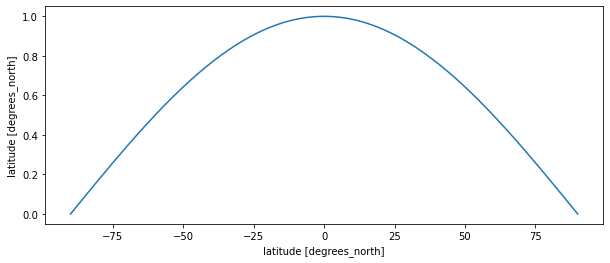

In [4]:
# Now, perform weighing to get true aggregate statistics
# 
# First, an example of weights by Earth's latitude
weights = np.cos(np.deg2rad(ds['hist']['lat']))
weights.name = 'weights'
weights.plot(figsize=(10, 4));

In [5]:
# Perform weighing on all datasets
ds_w = ca.dictorize(
    func = 'weight', 
    modeldict = ds,
)

ds_w['hist']

DatasetWeighted with weights along dimensions: lat

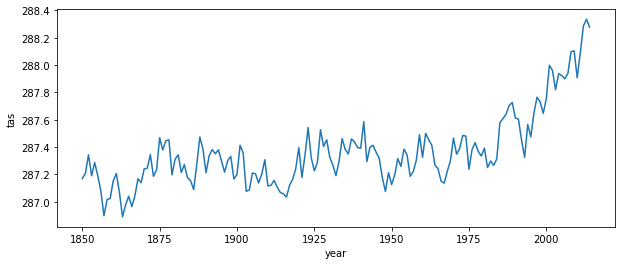

In [6]:
# Now look at global averages
# "_mt" for mean data at each time step (month)
ds_mt = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_w,
         # in aggs, roll arg is required below (even if empty)
        {'grps': ('lat', 'lon'), 'aggfunc': np.nanmean, 'roll': {}},
    ),
)


# "_my" for mean of each year
ds_my = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_mt,
         # in aggs, roll arg is required below (even if empty)
        {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
    ),
)

# Plot air surface temperature over recorded period in history
ds_my['hist']['tas'].plot(figsize=(10,4));

So 1850 - ~1980 may be more appropriate for historical average comparisons.

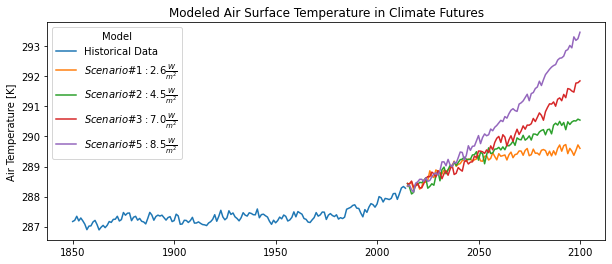

In [7]:
# Now, let's look at past vs. future for air temperatures!

param = 'tas' # for air temperatures of air at the surface 

fig, ax = plt.subplots(figsize=(10, 4))

for model in ds_my.keys():
    ds_my[model][param].plot(ax=ax, label=modeldict[model]['name'])

ax.set_xlabel('')
ax.set_ylabel(f"{vardict[param]['name']} [{vardict[param]['units']}]")
ax.set_title('Modeled Air Surface Temperature in Climate Futures')
ax.legend(title="Model");

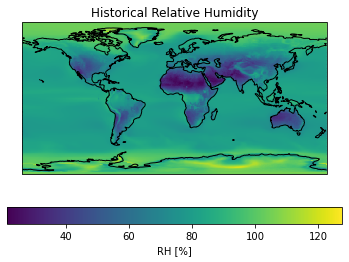

In [8]:
# Calculate baselines from subset of raw data
baseline = (
    ds['hist']
    .sel(time=slice('1850', '1980'))
    .mean('time')
)

# Plot on a map
ax = plt.subplot(projection=crs)

baseline['hurs'].plot(
    ax=ax, 
    transform=crs,
    cbar_kwargs={
        'orientation': 'horizontal',
        'label': 'RH [%]',
    }
)

# Add coastlines and format
ax.coastlines("110m", color="k")
ax.set_title('Historical Relative Humidity');

In [9]:
# Create differences between models and historical data 
ds_diffs = ds.copy()

ds_diffs['hist'] = baseline

ds_diffs = ca.dictorize(
    func = 'diff',
    modeldict = ca.nest_dicts(
        ds_diffs,
    ),
)

print(ds_diffs.keys())
ds_diffs['sp3']

dict_keys(['sp1', 'sp2', 'sp3', 'sp5'])


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1032)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(408, 192, 288), meta=np.ndarray>
    hurs     (time, lat, lon) float32 dask.array<chunksize=(347, 192, 288), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(325, 192, 288), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(288, 192, 288), meta=np.ndarray>

In [12]:
# Select only the last date in each ds_diffs dataset
d = ca.dictorize(
    func = 'sel',
    modeldict = ca.nest_dicts(
        ds_diffs,
        {'args': {'time': '2100-12-15'}},
    ),
)

# Consider surface air temperature
param = 'tas'

###########################################################
# Create new DataArrays as model names (for combining)
for k in d.keys():
    d[k][k] = d[k]['tas'].copy()


    # 
print(np.vstack(tuple([d[k]['tas'].values for k in d.keys()])).shape)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2100-12-15 12:00:00
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    hurs     (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    sp1      (time, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>

(4, 192, 288)

In [45]:
model_data = np.vstack(tuple([d[k]['tas'].values for k in d.keys()]))

dplot = xr.Dataset(
    data_vars = {
        k: (['model', 'lat', 'lon'], model_data)
    },
    coords = {
        'model': np.array(list(d)),
        'lat': d['sp1']['lat'],
        'lon': d['sp1']['lon'],
    }
)

dplot = dplot.rename({'sp5': 'tas'})
dplot

<xarray.Dataset>
Dimensions:  (model: 4, lat: 192, lon: 288)
Coordinates:
  * model    (model) <U3 'sp1' 'sp2' 'sp3' 'sp5'
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    tas      (model, lat, lon) float32 23.34 23.34 23.34 ... 15.25 15.25 15.25

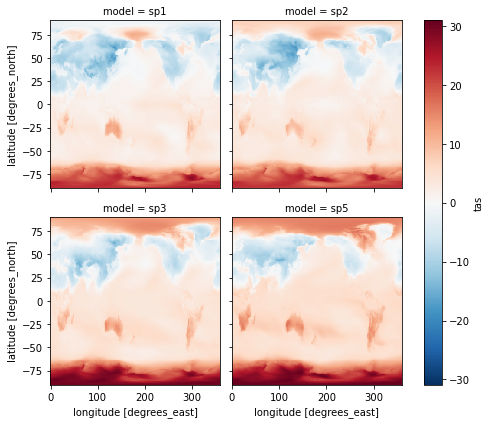

In [47]:
dplot['tas'].plot(col='model', col_wrap=2)

In [135]:
def plot_diff(d, var, crs, vardict, modeldict):
    """
    .
    """
    for k in d.keys():
        d[k][k] = d[k][var].copy()
    
    # ds = xr.combine_by_coords([d[k][k] for k in d.keys()])
    
    models = np.array(list(d))
    model_data = np.vstack(tuple([d[k][var].values for k in models]))

    ds = xr.Dataset(
        data_vars = {
            k: (['model', 'lat', 'lon'], model_data)
        },
        coords = {
            'model': models,
            'lat': d[models[0]]['lat'],
            'lon': d[models[0]]['lon'],
        }
    )

    ds = ds.rename({models[-1]: var})
    
    dplot = ds[var].plot(
        col='model', 
        col_wrap=2,
        transform=crs,
        figsize=(10, 10),
        # cmap='RdYlBu_r', vmin=-30, vmax=30, extend='neither',
        cbar_kwargs={
            "orientation": "horizontal",
            'anchor': (0, 3),
            # "shrink": 0.8,
            "aspect": 20,
            'label': vardict[var]['name']+' '+vardict[var]['units'],
            # 'ticks': [-35, 0, 35],
            'spacing': 'proportional',
        },
        subplot_kws={
            'projection': crs,
        },
    )
    
    for i, ax in enumerate(dplot.axes.flatten()):
        sc = modeldict[models[i]]['name'].split(':')[0]
        rcp = modeldict[models[i]]['name'].split(':')[1]
        ax.set_xlim(-180, 180)
        # Add coastlines and format
        ax.coastlines("110m", color="k")
        ax.set_title('')
        ax.annotate(
            f'{sc}$\n${rcp}', 
            (-170, -40), # in lat, lon
            # xycoords = 'axes fraction',
            ha='left', va='center',
            color='black',
            fontsize=10,
        ).set(
            bbox={
                'facecolor': 'white', 
                'edgecolor': 'black'
            }
        )
    plt.suptitle(
        f"{vardict[var]['name']} in {len(models)} climate models\n(NCAR CESM2)",
        fontsize=20,
        ha='center', va='center',
        x=0.5, y=0.91,
    )

In [ ]:
d = ca.dictorize(
    func = 'sel',
    modeldict = ca.nest_dicts(
        ds_diffs,
        {'args': {'time': '2100-12-15'}},
    ),
)

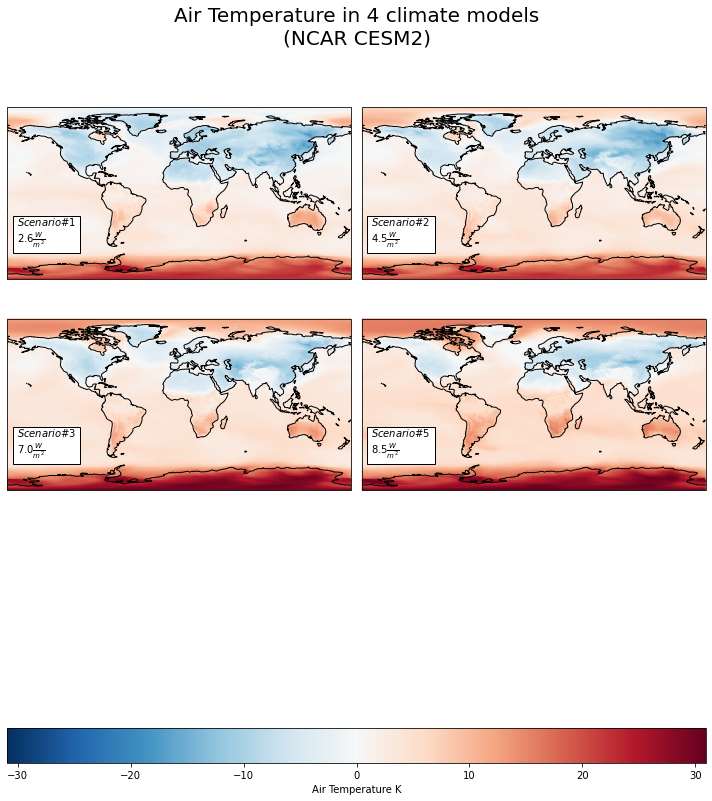

In [115]:
param = 'tas'
plot_diff(d, param, crs, vardict, modeldict)